# Style Transfer
* https://www.kaggle.com/code/ohseokkim/transfering-style

In [ ]:
import os
import gc
import random
from datetime import datetime
import requests
from io import BytesIO

from PIL import Image

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(6) # Seed 고정

In [ ]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/'
else:
    data_path = '../../data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df.loc[3896, 'artist'] = 'Titian'
df.loc[3986, 'artist'] = 'Alfred Sisley'
df.head()

id          img_path            artist
0   0  ./train/0000.jpg   Diego Velazquez
1   1  ./train/0001.jpg  Vincent van Gogh
2   2  ./train/0002.jpg      Claude Monet
3   3  ./train/0003.jpg       Edgar Degas
4   4  ./train/0004.jpg  Hieronymus Bosch

In [ ]:
count_df = df.groupby('artist')[['id']].agg('count').rename(columns={'id': 'count'}).sort_values(by='count',ascending=False).iloc[:10].reset_index()
count_df

artist  count
0       Vincent van Gogh    629
1            Edgar Degas    489
2          Pablo Picasso    303
3  Pierre-Auguste Renoir    233
4           Paul Gauguin    220
5        Albrecht Du rer    220
6         Francisco Goya    204
7              Rembrandt    181
8           Marc Chagall    173
9                 Titian    173

In [ ]:
# count_df['img_path'] = count_df['artist'].apply(lambda a: df.loc[df['artist']==a, 'img_path'])
count_df['img_path']=count_df['artist'].apply(lambda name: df.loc[df['artist']==name, 'img_path'].values[0])
count_df

artist  count          img_path
0       Vincent van Gogh    629  ./train/0001.jpg
1            Edgar Degas    489  ./train/0003.jpg
2          Pablo Picasso    303  ./train/0018.jpg
3  Pierre-Auguste Renoir    233  ./train/0005.jpg
4           Paul Gauguin    220  ./train/0047.jpg
5        Albrecht Du rer    220  ./train/0042.jpg
6         Francisco Goya    204  ./train/0014.jpg
7              Rembrandt    181  ./train/0013.jpg
8           Marc Chagall    173  ./train/0076.jpg
9                 Titian    173  ./train/0019.jpg

In [ ]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values
    return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values, df['artist'].values

In [ ]:
img_paths, labels = get_data(count_df)
print(img_paths, labels)

['/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0001.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0003.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0018.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0005.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0047.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0042.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0014.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0013.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0076.jpg'
 '/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/./train/0019.jpg'] ['Vincent van Gogh' 'Edgar Degas' 'Pablo Picasso' 'Pierre-Auguste Renoir'
 'Paul Gauguin' 'Albrecht Du rer' 'Francisco Goya' 'Rembrandt'
 'Marc Chagall' 'Titian']


In [ ]:
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def load_image(img_path, max_size=520, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    print(image.size)
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    print(size)
    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.CenterCrop(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [ ]:
# load in content and style image
content = load_image('/content/drive/MyDrive/Colab Notebooks/ai6th/data/artists/bear.jpg').to(device)
# Resize style to match content, makes code easier
user_idx = 2
style = load_image(img_paths[user_idx]).to(device)
print(labels[user_idx])

(1024, 1024)
520
(396, 601)
520
Pablo Picasso


In [ ]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    print(image.shape)

    return image

(520, 520, 3)
(520, 520, 3)


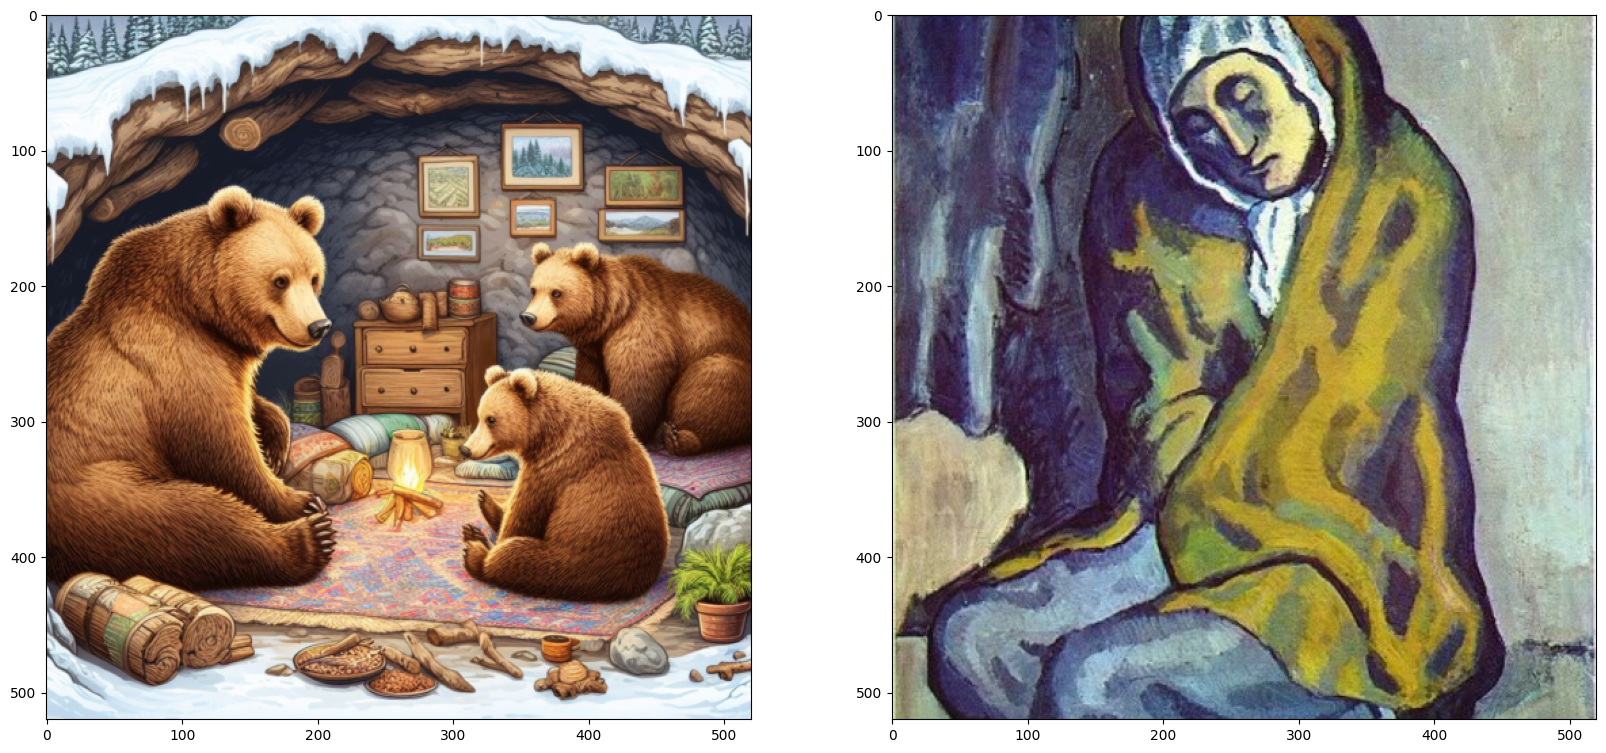

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [ ]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
    """

    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)

    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [ ]:
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e3  # beta

Total loss:  2044.091552734375
(520, 520, 3)


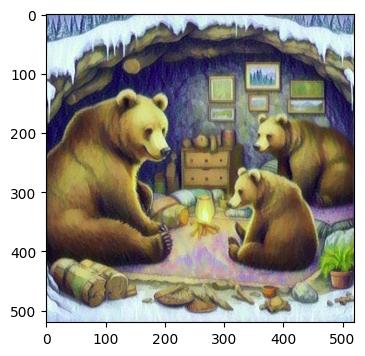

Total loss:  617.3190307617188
(520, 520, 3)


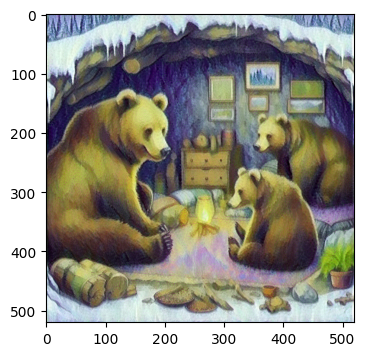

Total loss:  288.8890380859375
(520, 520, 3)


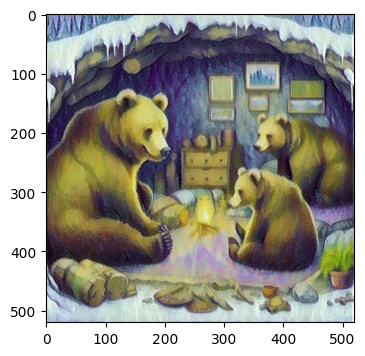

Total loss:  160.10084533691406
(520, 520, 3)


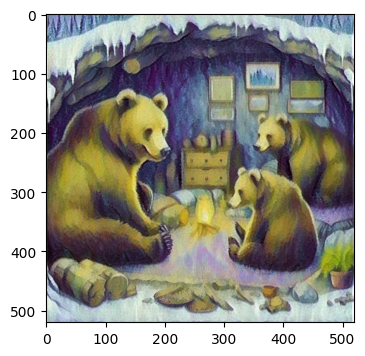

Total loss:  101.84123229980469
(520, 520, 3)


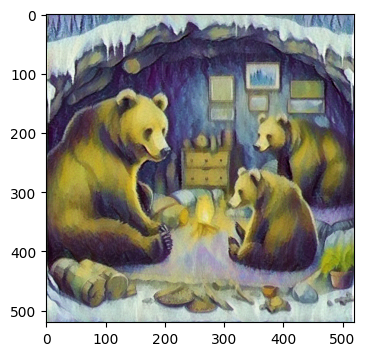

In [ ]:
# for displaying the target image, intermittently
show_every = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5001  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.figure(figsize=(4,4))
        plt.imshow(im_convert(target))
        plt.show()

(520, 520, 3)
(520, 520, 3)
(520, 520, 3)


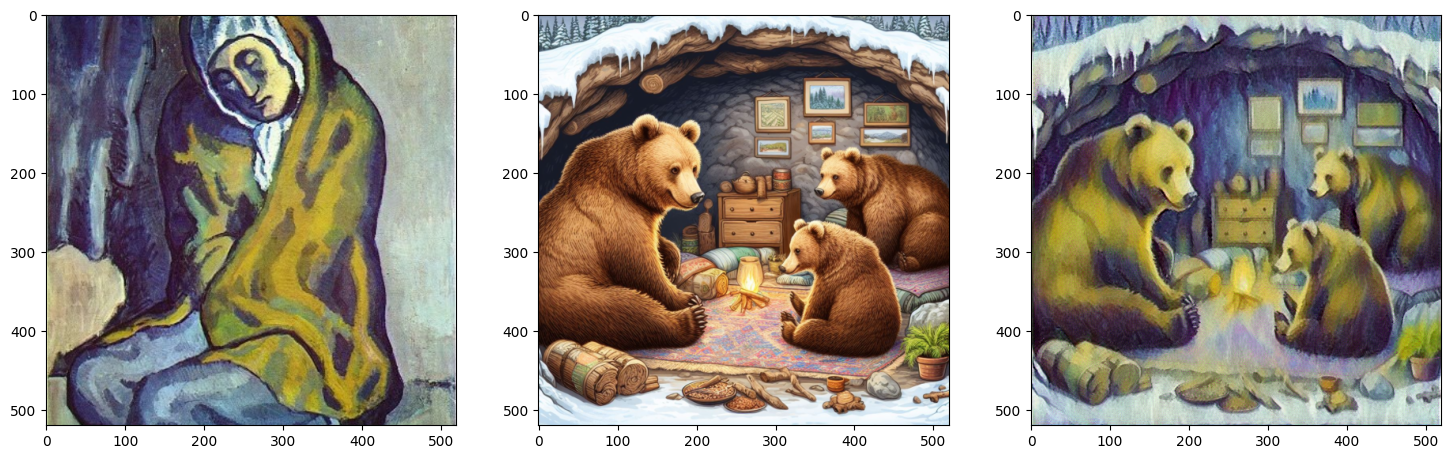

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 6))
ax0.imshow(im_convert(style))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))